In [68]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.units as u
from numpy import trapz
import os
from colossus.cosmology import cosmology
P18 = cosmology.setCosmology('planck18-only') # consistent with the Peak Patch setup
P18_astropy = P18.toAstropy()
P18_omegam = P18.Om0
P18_omegab = P18.Ob0
import healpy as hp
P18_h = P18.h
import matplotlib as mpl
# set fontsize for plots
font = {'family' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)
import warnings
warnings.filterwarnings('ignore')

In [69]:
fid_img = fits.open("/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_OM32_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk.fits")
hdr = fid_img[0].header
img = fid_img[0].data
radius = float(hdr['RADIUS'].replace('=',''))
res    = float(hdr['RES'].replace('=',''))
arcmin_per_pix = (radius*u.deg/res).to(u.arcmin)
z = 0.5
mpc_per_arcmin_P18 = P18_astropy.kpc_comoving_per_arcmin(z).to(u.Mpc / u.arcmin)
rad_in_mpc = img.shape[0]//2 * arcmin_per_pix * mpc_per_arcmin_P18 # the radius of the first image in comoving Mpc
fid_img.close()

In [70]:
def integrate(profile, r, upper_bound, errors=None):
    reimann_sum = 0
    error_sum   = 0
    delta_r = r[1]-r[0]
    ub_idx = (np.abs(r - upper_bound)).argmin()
    for i in range(ub_idx+1):    
        reimann_sum += r[i]*profile[i]*delta_r
        if errors is not None:
            error_sum += (delta_r*r[i]*errors[i])**2
    return(reimann_sum*np.pi, np.sqrt(error_sum)*np.pi)

In [71]:
def get_annulus(image):
    center = [int(image.shape[0]/2), int(image.shape[1]/2)]
    # R1 and R2 vary with image size
    # R1 is 1/2 of way from center of image
    R1   = int(center[0]/2.)
    # R2 is 3/4 of way from center of image
    R2   = int(3*center[1]/4.)
    imin = center[0] - R2
    imax = center[0] + R2 + 1
    jmin = center[1] - R2
    jmax = center[1] + R2 + 1
    target = []
    for i in np.arange(imin, imax):
        for j in np.arange(jmin, jmax):
            ij = np.array([i,j])
            dist = np.linalg.norm(ij - np.array(center))
            if dist > R1 and dist <= R2:
                target.append(image[i][j])
    target = np.array(target)
    return np.average(target)

# Settings

In [72]:
fix_density = True
constant_comoving = False

omegam_varied = np.linspace(P18_omegam-0.1,P18_omegam+0.1,5)
if fix_density:
    omegab_varied = omegam_varied*P18_omegab/P18_omegam # fix the baryon fraction
    omh2 = P18_omegam*P18_h**2
    h_varied = np.sqrt(omh2/omegam_varied)
    H0_varied = 100*h_varied
    print("H0 varied: ", h_varied)
    
else:
    omegab_varied = np.full(len(omegam_varied),P18_omegab)
    H0_varied = np.full(len(omegam_varied),P18.h*100)
    

if fix_density:
    addon='_fix_physdens'
    omegab_varied = omegam_varied*P18_omegab/P18_omegam # fix the baryon fraction
else:
    addon=''


# add text in whitespace describing the set of cosmological variations
if fix_density:
    cosmo_label = 'Cosmo2'
    text1 = r"Cosmo2: $\Omega_M h^2$ fixed,"
    text2 = r"$H_0$ varied"
else:
    cosmo_label= 'Cosmo1'
    text1 = r"Cosmo1: $\Omega_M h^2$ varied,"
    text2 = r"$H_0$ fixed"
    


H0 varied:  [0.81515848 0.73433705 0.6736     0.62580529 0.58692566]


ValueError: x and y must have same first dimension, but have shapes (1,) and (100,)

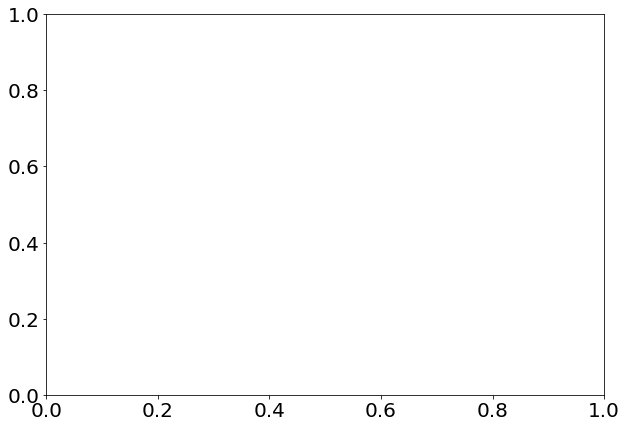

In [73]:
plt.figure(figsize=[10,7])
colors = ['b','g','r','c','m']
for i in range(len(omegam_varied)):
    OMstring = "OM{:d}{:s}".format(int(round(omegam_varied[i]*100)), addon)
    new_cosmo = cosmology.setCosmology('newcosmo', params=cosmology.cosmologies['planck18-only'], Om0=omegam_varied[i], Ob0=omegab_varied[i], H0=H0_varied[i])
    new_cosmo_astropy = new_cosmo.toAstropy()
    # plot the dark energy density as a function of redshift
    zrange = np.linspace(0, 2, 100)
    plt.plot(z, new_cosmo_astropy.Ode(zrange), label=r'$\Omega_{{\Lambda,0}}$={:.2f}'.format(1-omegam_varied[i]), linestyle='--', color=colors[i])
    plt.plot(z, new_cosmo_astropy.Om(zrange), label=r'$\Omega_{{M,0}}$={:.2f}'.format(omegam_varied[i]), linestyle='solid', color=colors[i])
    plt.xlabel('z')
    plt.ylabel(r'$\Omega$')
    plt.legend()
    

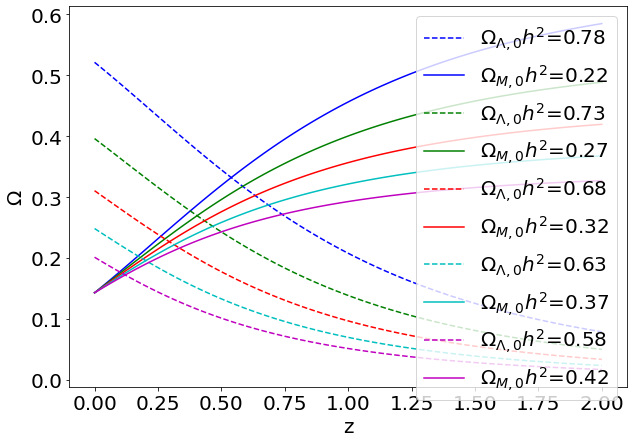

In [ ]:
plt.figure(figsize=[10,7])
colors = ['b','g','r','c','m']
for i in range(len(omegam_varied)):
    OMstring = "OM{:d}{:s}".format(int(round(omegam_varied[i]*100)), addon)
    new_cosmo = cosmology.setCosmology('newcosmo', params=cosmology.cosmologies['planck18-only'], Om0=omegam_varied[i], Ob0=omegab_varied[i], H0=H0_varied[i])
    new_cosmo_astropy = new_cosmo.toAstropy()
    # plot the dark energy density as a function of redshift
    zrange = np.linspace(0, 2, 100)
    plt.plot(zrange, new_cosmo_astropy.Ode(z)*new_cosmo_astropy.h**2, label=r'$\Omega_{{\Lambda,0}}h^2$={:.2f}'.format(1-omegam_varied[i]), linestyle='--', color=colors[i])
    plt.plot(zrange, new_cosmo_astropy.Om(z)*new_cosmo_astropy.h**2, label=r'$\Omega_{{M,0}}h^2$={:.2f}'.format(omegam_varied[i]), linestyle='solid', color=colors[i])
    plt.xlabel('z')
    plt.ylabel(r'$\Omega$')
    plt.legend()

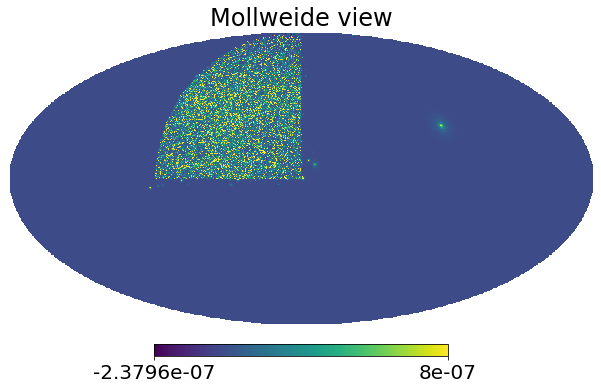

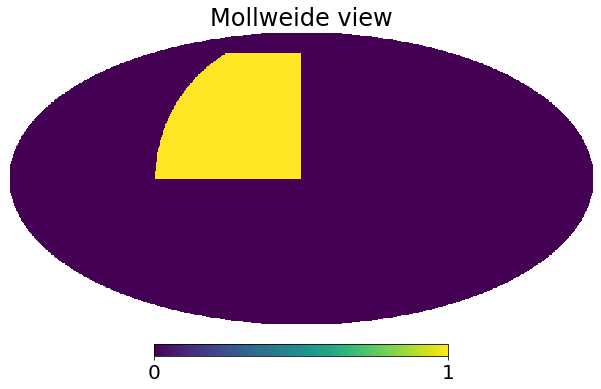

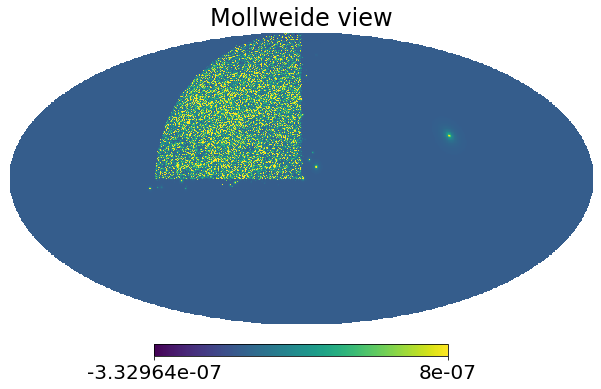

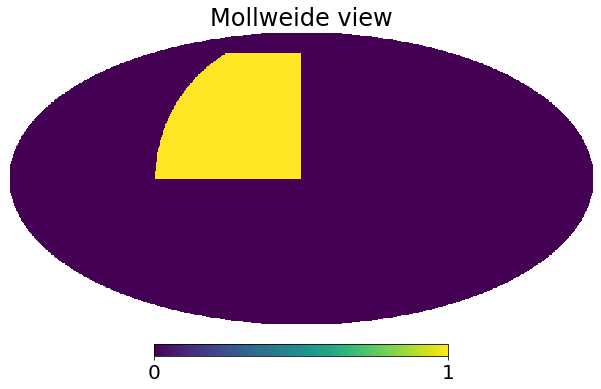

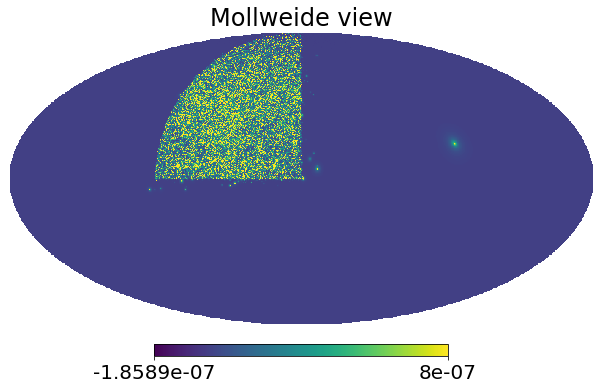

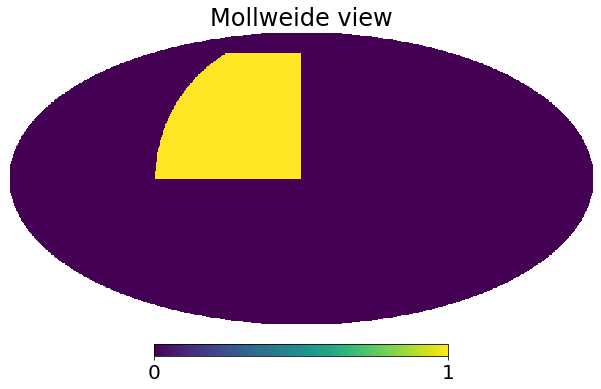

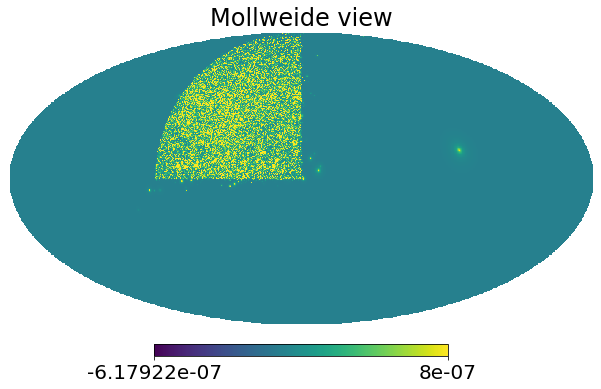

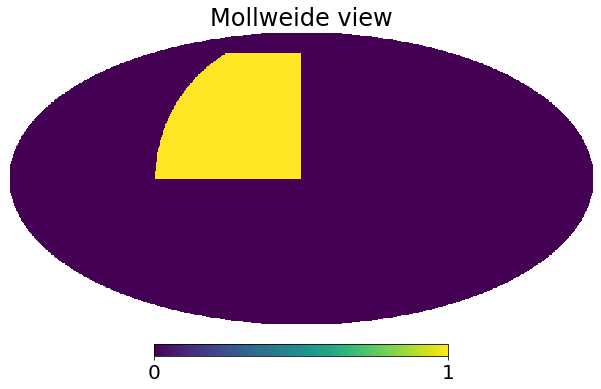

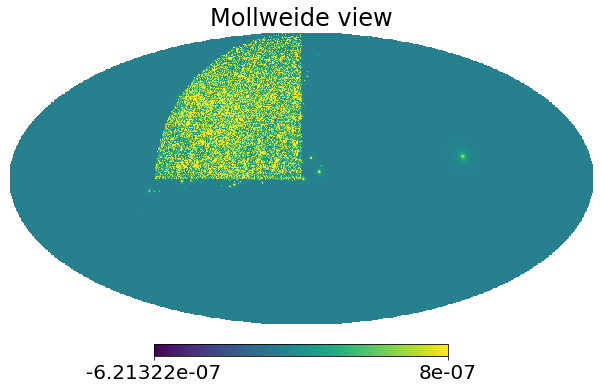

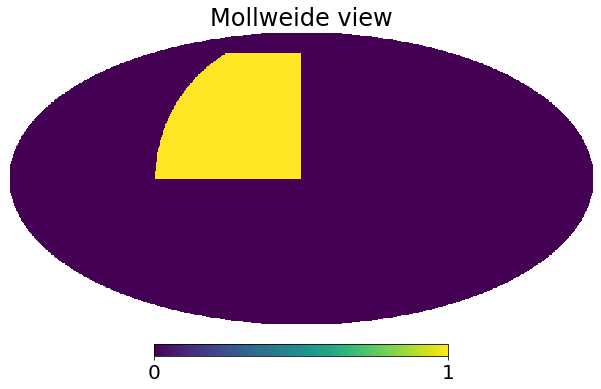

In [74]:
# get the average y for each map
averages = []
for OMstring in ["OM22", "OM27", "OM32", "OM37", "OM42"]:
    if "OM32" in OMstring:
        y = hp.read_map(f"/mnt/raid-cita/mlokken/pkpatch/ymaps/2400Mpc_n442_nb28_nt4_{OMstring}_merge_battaglia_car_1p6arcmin_cutoff4_4096_hpx.fits")
    else:
        OMstring += addon
        y = hp.read_map(f"/mnt/raid-cita/mlokken/pkpatch/ymaps/2400Mpc_n442_nb28_nt4_{OMstring}_merge_battaglia_car_1p6arcmin_cutoff4_4096_hpx.fits")
    hp.mollview(y, max=8e-7)
    mask = hp.read_map("/mnt/raid-cita/mlokken/pkpatch/eighthsky_mask_nopole_midleftup.fits")
    hp.mollview(mask)
    average = np.mean(y[mask==1])
    averages.append(average)

Plots for fixed redshift range and angular smoothing

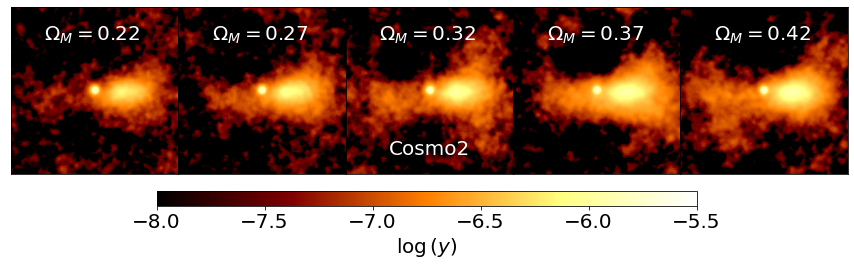

<Figure size 432x288 with 0 Axes>

In [75]:
i = 0
fig, ax = plt.subplots(1,5,figsize=[15,4])
for OMstring in ["OM22", "OM27", "OM32", "OM37", "OM42"]:
    OMstring += addon
    hdu = fits.open(f"/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_{OMstring}_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk.fits")
    shape = hdu[0].shape[0]
    cutoff = 140
    img = (hdu[0].data-get_annulus(hdu[0].data))[cutoff:shape-cutoff, cutoff:shape-cutoff]
    img[img<1e-8] = 1e-8
    im = ax[i].imshow(np.log10(img), vmin=-8, vmax=-5.5, cmap='afmhot')
    # Hide X and Y axes label marks
    ax[i].xaxis.set_tick_params(labelbottom=False)
    ax[i].yaxis.set_tick_params(labelleft=False)
    ax[i].text(40, 40, r"$\Omega_M = 0.{:s}$".format(OMstring[2:4]), color='white')
    # Hide X and Y axes tick marks
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    i+=1

# text in the lower left corner

plt.text(0.5, 0.15, cosmo_label, horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes, fontsize=20, color = 'white')
# add a new axis below for a horizontal colorbar
fig.subplots_adjust(bottom=0.1)
plt.subplots_adjust(wspace=0.0, hspace=0.17)
ax_cbar = fig.add_axes([0.26, 0.09, 0.5, 0.05])
cbar = fig.colorbar(im, cax=ax_cbar, orientation='horizontal', label=r'$\log{(y)}$')
plt.savefig("../../plots/paper2/{:s}_stack_images.pdf".format(cosmo_label), bbox_inches="tight", dpi=300)
plt.show()
plt.clf()


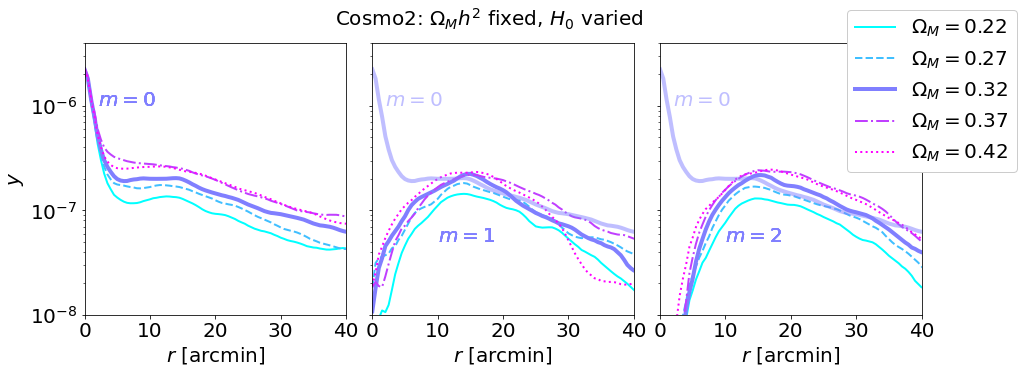

In [76]:
mmax = 2
figlen = 5*(mmax+1)
fig, ax = plt.subplots(1,mmax+1,figsize=[figlen,5], sharey=True)
colormap = 'cool'
# sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0.22, vmax=0.42))
# get a color map that I can call by index
cm = plt.cm.get_cmap(colormap)
xmax = 40
log = True
integrals = []
linestyles = ['solid', 'dashed', 'solid', 'dashdot', 'dotted']
linewidths = [2,2,4,2,2]
for i, OMstring in enumerate(["OM22", "OM27", "OM32", "OM37", "OM42"]):
    OMstring += addon
    
    for n, m in enumerate(range(mmax+1)):
        
        hankel = np.loadtxt(f"/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_{OMstring}_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m{m}.txt")
        x = np.arange(len(hankel[:,0]))*arcmin_per_pix
        y = hankel[:,1]
        if m==0:
            # y -= np.average(hankel[:,1][-40:])
            y -= averages[i]
            label=r"$\Omega_M=0.{:d}$".format(int(OMstring[2:4]))
        else:
            label = ''
        ax[n].plot(x, y, color =cm(i/4), linestyle=linestyles[i], label=label, linewidth=linewidths[i])
        if m==0:
            xtextpos = 2
            ytextpos = 10**-6
        elif fix_density and m==2:
            xtextpos = 10
            ytextpos = .5e-7
        elif not fix_density and (m==2 or m==1):
            xtextpos = 10
            ytextpos = .9e-7
        elif fix_density and m==1:
            xtextpos = 10
            ytextpos = .5e-7
        else:
            xtextpos = 5
            ytextpos = .6*10**-7
        # text below the curve
        ax[n].text(xtextpos, ytextpos, r"$m={:d}$".format(m), fontsize=20, color=cm(2/4), alpha=1)
        ax[n].set_xlim([0,xmax])
        if log:
            ax[n].set_yscale('log')
            ax[n].set_ylim([1e-8,4e-6])
        else:
            ax[n].set_ylim([0,2.5e-6])
        ax[n].set_xlabel("$r$ [arcmin]")


fig.legend(loc='upper right', framealpha=1)

ax[0].set_ylabel("$y$")
OMstring0 = "OM32"+addon
hankel0 = np.loadtxt(f"/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_{OMstring0}_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m0.txt")
x0 = np.arange(len(hankel0[:,0]))*arcmin_per_pix
y0= hankel0[:,1]
y0 -= averages[2]
for n in range(1, mmax+1):  
    # y -= np.average(hankel[:,1][-40:])
    ax[n].plot(x0, y0, color =cm(2/4), linestyle=linestyles[2], linewidth=linewidths[2], alpha=0.5)
    ax[n].text(2,10**-6, r"$m=0$", fontsize=20, color=cm(2/4), alpha=0.5)
    
# cbar = plt.colorbar(sm)
# cbar.set_label(r"$\Omega_M$")
# ax[0].text(0.3, 0.9, text1, horizontalalignment='center', verticalalignment='center', transform=ax[n].transAxes, fontsize=20)
plt.suptitle(text1+ ' ' + text2, fontsize=20)
# reduce space between plots
plt.subplots_adjust(wspace=0.1, hspace=0.0)

# plt.tight_layout()
# ax[0].text(0.3, 0.85, text2, horizontalalignment='center', verticalalignment='center', transform=ax[n].transAxes, fontsize=20)
# secax = ax.secondary_xaxis('top', functions=(arcmin_to_mpc, mpc_to_arcmin))
# secax.set_xlabel('$r$ [cMpc, fiducial cosmology]')


plt.savefig("../../plots/paper2/{:s}_stack_profiles_mmax_{:d}.pdf".format(cosmo_label, mmax), bbox_inches="tight", dpi=300)


### Can we find a simple scaling relation?

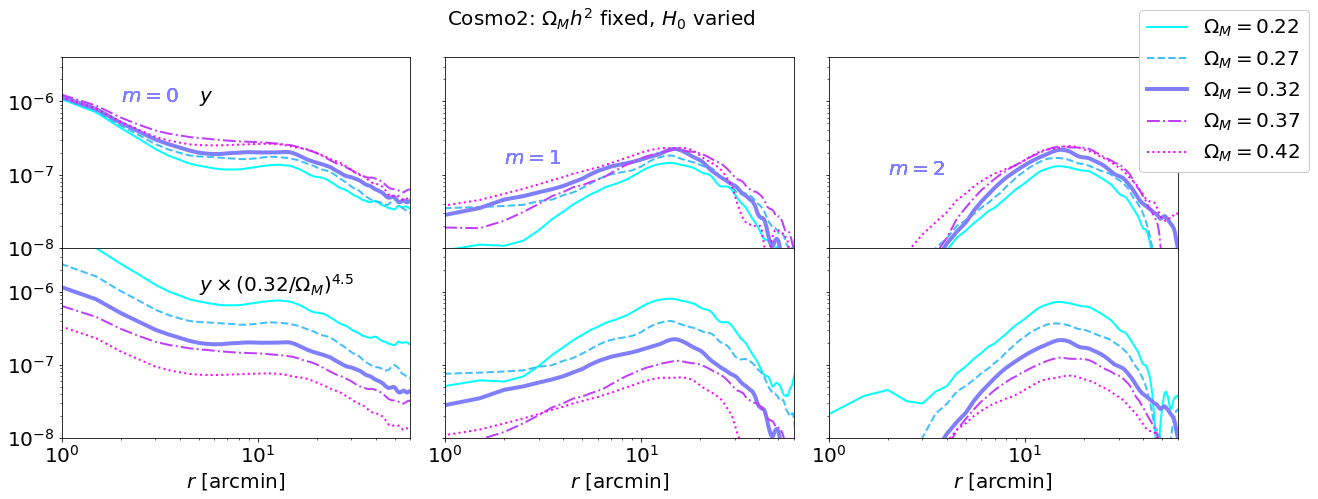

In [77]:
mmax = 2

figlen = 5*(mmax+1)
fig, ax = plt.subplots(2,mmax+1,figsize=[figlen+5,7], sharey=True, sharex=True)
colormap = 'cool'
# sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0.22, vmax=0.42))
# get a color map that I can call by index
cm = plt.cm.get_cmap(colormap)
xmax = 60
log = True
integrals = []
linestyles = ['solid', 'dashed', 'solid', 'dashdot', 'dotted']
linewidths = [2,2,4,2,2]

for i, OMstring in enumerate(["OM22", "OM27", "OM32", "OM37", "OM42"]):
    OMstring += addon
    
    for n, m in enumerate(range(mmax+1)):
        
        hankel = np.loadtxt(f"/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_{OMstring}_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m{m}.txt")
        x = np.arange(len(hankel[:,0]))*arcmin_per_pix
        y = hankel[:,1]
        if m==0:
            # y -= np.average(hankel[:,1][-40:])
            y -= averages[i]
            label=r"$\Omega_M=0.{:d}$".format(int(OMstring[2:4]))
        else:
            label = ''
        ax[0,n].plot(x, y, color =cm(i/4), linestyle=linestyles[i], label=label, linewidth=linewidths[i])
        ax[1,n].plot(x, y*(omegam_varied[2]/omegam_varied[i])**4.5, color =cm(i/4), linestyle=linestyles[i], linewidth=linewidths[i])
        if m==0:
            xtextpos = 2
            ytextpos = 10**-6
        elif fix_density and m==2:
            xtextpos = 2
            ytextpos = 1e-7
        elif not fix_density and (m==2 or m==1):
            xtextpos = 2
            ytextpos = 1.4e-7
        elif fix_density and m==1:
            xtextpos = 2
            ytextpos = 1.4e-7
        else:
            xtextpos = 2
            ytextpos = 1.1*10**-7
        # text below the curve
        ax[0,n].text(xtextpos, ytextpos, r"$m={:d}$".format(m), fontsize=20, color=cm(2/4), alpha=1)
        ax[0,n].set_xlim([0,xmax])
        ax[1,n].set_xlim([0,xmax])
        if log:
            ax[0,n].set_yscale('log')
            ax[0,n].set_ylim([1e-8,4e-6])
            ax[1,n].set_yscale('log')
            ax[1,n].set_ylim([1e-8,4e-6])
            ax[0,n].set_xscale('log')
            ax[1,n].set_xscale('log')
            ax[0,n].set_xlim([1,xmax])
            ax[1,n].set_xlim([1,xmax])
        else:
            ax[0,n].set_ylim([0,1e-6])
        ax[1,n].set_xlabel("$r$ [arcmin]")

ax[1,0].text(5, 10**-6, r"$y\times (0.32/\Omega_M)^{4.5}$", fontsize=20)
ax[0,0].text(5, 10**-6, r"$y$", fontsize=20)
fig.legend(loc='upper right', framealpha=1)

plt.suptitle(text1+ ' ' + text2, fontsize=20)
# reduce space between plots
plt.subplots_adjust(wspace=0.1, hspace=0.0)

# plt.savefig("../../plots/paper2/{:s}_stack_profiles_mmax_{:d}.pdf".format(cosmo_label, mmax), bbox_inches="tight", dpi=300)


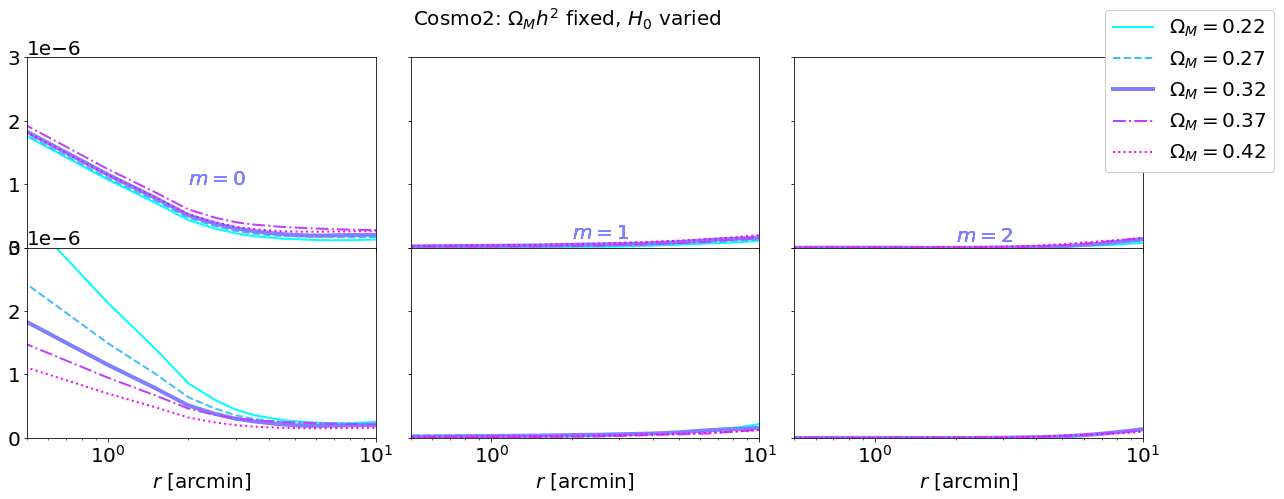

In [78]:
mmax = 2

figlen = 5*(mmax+1)
fig, ax = plt.subplots(2,mmax+1,figsize=[figlen+5,7], sharey=True, sharex=True)
colormap = 'cool'
# sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0.22, vmax=0.42))
# get a color map that I can call by index
cm = plt.cm.get_cmap(colormap)
xmax = 10
log = False
integrals = []
linestyles = ['solid', 'dashed', 'solid', 'dashdot', 'dotted']
linewidths = [2,2,4,2,2]

for i, OMstring in enumerate(["OM22", "OM27", "OM32", "OM37", "OM42"]):
    OMstring += addon
    
    for n, m in enumerate(range(mmax+1)):
        
        hankel = np.loadtxt(f"/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_{OMstring}_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m{m}.txt")
        x = np.arange(len(hankel[:,0]))*arcmin_per_pix
        y = hankel[:,1]
        if m==0:
            # y -= np.average(hankel[:,1][-40:])
            y -= averages[i]
            label=r"$\Omega_M=0.{:d}$".format(int(OMstring[2:4]))
        else:
            label = ''
        ax[0,n].plot(x, y, color =cm(i/4), linestyle=linestyles[i], label=label, linewidth=linewidths[i])
        ax[1,n].plot(x, y*(omegam_varied[2]/omegam_varied[i])**1.8, color =cm(i/4), linestyle=linestyles[i], linewidth=linewidths[i])
        if m==0:
            xtextpos = 2
            ytextpos = 10**-6
        elif fix_density and m==2:
            xtextpos = 2
            ytextpos = 1e-7
        elif not fix_density and (m==2 or m==1):
            xtextpos = 2
            ytextpos = 1.4e-7
        elif fix_density and m==1:
            xtextpos = 2
            ytextpos = 1.4e-7
        else:
            xtextpos = 2
            ytextpos = 1.1*10**-7
        # text below the curve
        ax[0,n].text(xtextpos, ytextpos, r"$m={:d}$".format(m), fontsize=20, color=cm(2/4), alpha=1)
        ax[0,n].set_xlim([0,xmax])
        ax[1,n].set_xlim([0,xmax])
        if log:
            ax[0,n].set_yscale('log')
            ax[0,n].set_ylim([1e-8,4e-6])
            ax[1,n].set_yscale('log')
            ax[1,n].set_ylim([1e-8,4e-6])
            ax[0,n].set_xscale('log')
            ax[1,n].set_xscale('log')
            ax[0,n].set_xlim([1,xmax])
            ax[1,n].set_xlim([1,xmax])
        else:
            # ax[0,n].set_ylim([0,1e-6])
            ax[0,n].set_ylim([0,3e-6])
            ax[0,n].set_xscale('log')
            ax[1,n].set_xscale('log')
            ax[0,n].set_xlim([.5,xmax])
            ax[1,n].set_xlim([.5,xmax])
        ax[1,n].set_xlabel("$r$ [arcmin]")

# ax[1,0].text(5, 10**-6, r"$y\times (0.32/\Omega_M)^{1}$", fontsize=20)
# ax[0,0].text(5, 10**-6, r"$y$", fontsize=20)
fig.legend(loc='upper right', framealpha=1)

plt.suptitle(text1+ ' ' + text2, fontsize=20)
# reduce space between plots
plt.subplots_adjust(wspace=0.1, hspace=0.0)

# plt.savefig("../../plots/paper2/{:s}_stack_profiles_mmax_{:d}.pdf".format(cosmo_label, mmax), bbox_inches="tight", dpi=300)


Text(0, 0.5, '$y$')

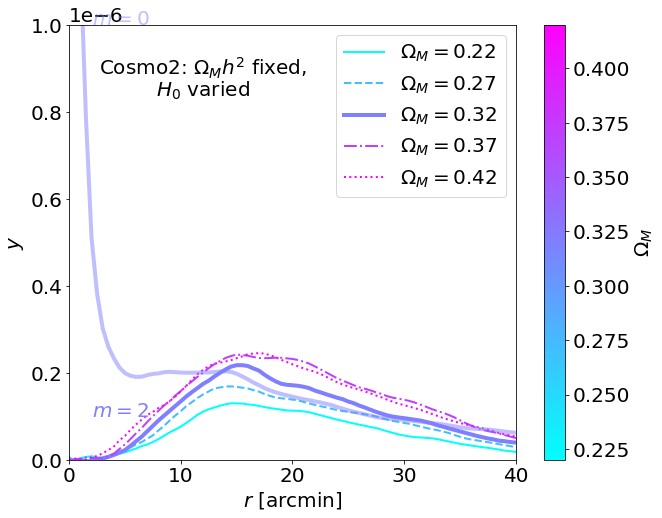

In [79]:
i=0
fig, ax = plt.subplots(1,1,figsize=[10,8])
colormap = 'cool'
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0.22, vmax=0.42))
# get a color map that I can call by index
cm = plt.cm.get_cmap(colormap)

integrals = []
xmax = 40
linestyles = ['solid', 'dashed', 'solid', 'dashdot', 'dotted']
linewidths = [2,2,4,2,2]
for OMstring in ["OM22", "OM27", "OM32", "OM37", "OM42"]:
    OMstring += addon
    if fix_density:
        # m = 2
        m=2
    else:
        m=1
        
    hankel = np.loadtxt(f"/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_{OMstring}_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m{m}.txt")
    x = np.arange(len(hankel[:,0]))*arcmin_per_pix
    y = hankel[:,1]
    label=r"$\Omega_M=0.{:d}$".format(int(OMstring[2:4]))
    ax.plot(x, y, color =cm(i/4), linestyle=linestyles[i], label=label, linewidth=linewidths[i])
    i+=1

    
    
OMstring = "OM32"+addon
hankel = np.loadtxt(f"/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_{OMstring}_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m0.txt")
x = np.arange(len(hankel[:,0]))*arcmin_per_pix
y= hankel[:,1]
# y -= np.average(hankel[:,1][-40:])
y -= averages[2]
ax.plot(x, y, color =cm(2/4), linestyle=linestyles[2], linewidth=linewidths[2], alpha=0.5)
# text by the curves
if fix_density and m==2:
    xtextpos = 2
    ytextpos = 10**-7
elif fix_density and m==1:
    xtextpos = 0.2
    ytextpos = 10**-7
else:
    xtextpos = 5
    ytextpos = .6*10**-7

ax.text(2,10**-6, r"$m=0$", fontsize=20, color=cm(2/4), alpha=0.5)
ax.text(xtextpos,ytextpos, r"$m={:d}$".format(m), fontsize=20, color=cm(2/4), alpha=1)

   

log = False
cbar = plt.colorbar(sm)
ax.legend(loc='upper right')
cbar.set_label(r"$\Omega_M$")
if log:
    plt.yscale('log')
    ax.set_ylim([1e-8,4e-6])
else:
    ax.set_ylim([0,1e-6])

ax.text(0.3, 0.9, text1, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=20)
ax.text(0.3, 0.85, text2, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=20)
xmax = 40
ax.set_xlim([0,xmax])


# secax = ax.secondary_xaxis('top', functions=(arcmin_to_mpc, mpc_to_arcmin))
# secax.set_xlabel('$r$ [cMpc, fiducial cosmology]')

ax.set_xlabel("$r$ [arcmin]")
ax.set_ylabel("$y$")
# plt.savefig("../../plots/paper2/{:s}_stack_profiles_m{:d}.pdf".format(cosmo_label,m), bbox_inches="tight", dpi=300)


In [50]:
mpc_per_arcmin_P18 = P18_astropy.kpc_comoving_per_arcmin(z).to(u.Mpc / u.arcmin)
print("The length of the x-axis corresponds to {:.2f}".format(xmax*u.arcmin* mpc_per_arcmin_P18))


TypeError: unsupported format string passed to numpy.ndarray.__format__

# Evaluate the integrals

/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_OM22_fix_physdens_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m0.txt
/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_OM22_fix_physdens_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m1.txt
/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_OM22_fix_physdens_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m2.txt
/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_OM22_fix_physdens_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m3.txt
/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_OM22_fix_physdens_massgt5e+1

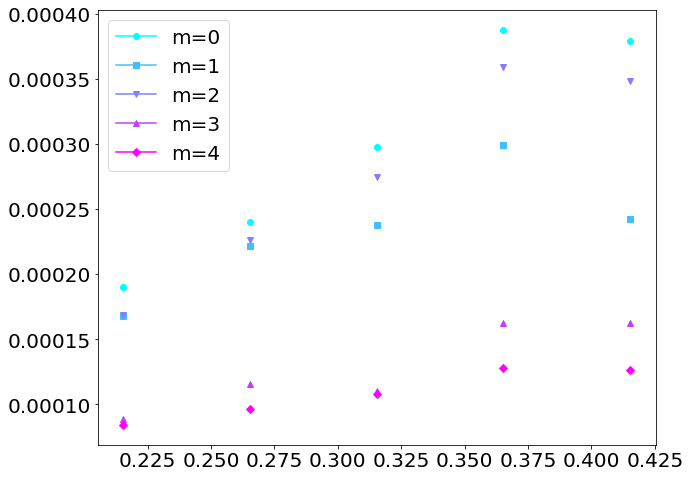

<Figure size 432x288 with 0 Axes>

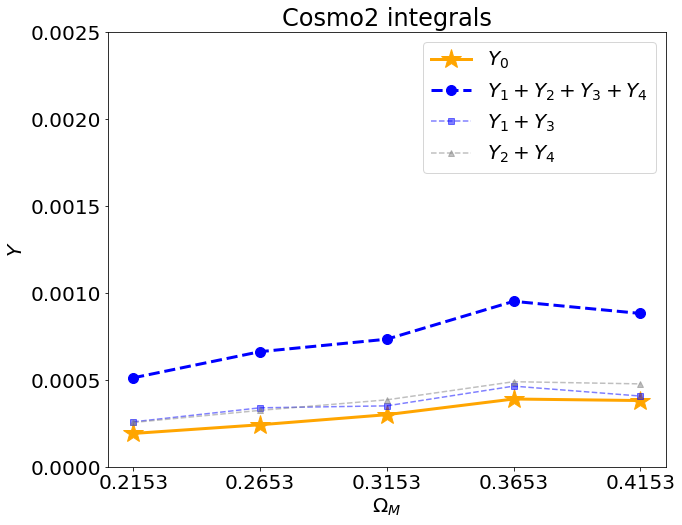

<Figure size 432x288 with 0 Axes>

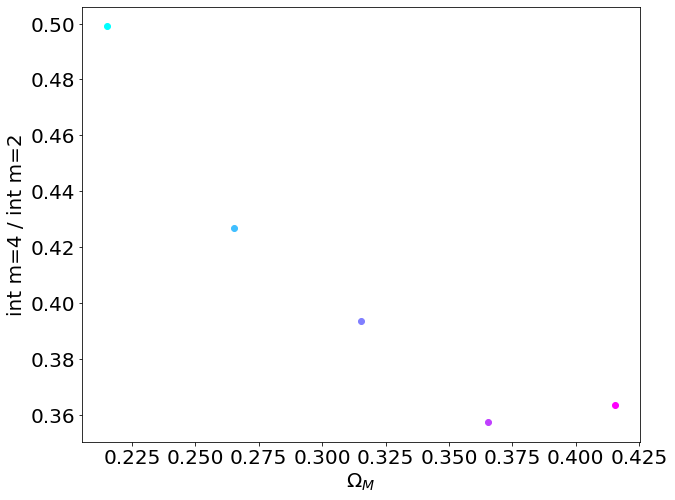

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'int m=2 / int m=1')

<Figure size 432x288 with 0 Axes>

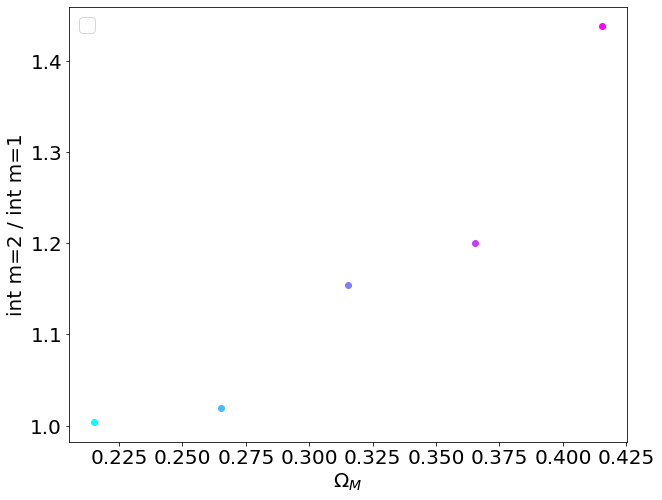

In [80]:

integrals = []
i = 0
for OMstring in ["OM22", "OM27", "OM32", "OM37", "OM42"]:
    OMstring += addon
    ints_cosmo = []
    
    for m in range(5):
        hankel = np.loadtxt(f"/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_{OMstring}_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m{m}.txt")
        print(f"/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/ymap_pkpatch_{OMstring}_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m{m}.txt")
        x = np.arange(len(hankel[:,0]))*arcmin_per_pix
        y = hankel[:,1]
        if m==0:
            # y -= np.average(hankel[:,1][-40:])
            y -= averages[i]
        area = integrate(y, x.value, xmax)[0]
        ints_cosmo.append(area)
    i+=1
    integrals.append(ints_cosmo) 
integrals = np.asarray(integrals)
plt.figure(figsize=[10,8])
OMstrings = ["OM22", "OM27", "OM32", "OM37", "OM42"]
markertypes = ['o', 's', 'v', '^', 'D']

# print the differences:
for i in range(4): # loop over cosmologies
    for j in range(5): # loop over m
        print(f"The difference between integral of cosmo {i} and cosmo{i+1} for m={j} is", integrals[i+1,j]-integrals[i,j])

for i in range(5): # loop over cosmologies
    
    for j in range(5): # loop over m
        print(f"m={j} integration, cosmology {OMstrings[i]}: ", integrals[i,j])
        plt.plot(omegam_varied[i], integrals[i,j], marker=markertypes[j], color=cm(j/4), label=f"m={j}")
    if i==0:
        plt.legend()
plt.show()
plt.clf()

# make a plot of the summed m=1, 2, and 4 integrals
plt.figure(figsize=[10,8])
sum = []
sumodd = []
sumeven = []
for i in range(5): # loop over cosmologies
    sum.append(integrals[i,1]+ integrals[i,2]+ integrals[i,3] + integrals[i,4])
    sumodd.append(integrals[i,1]+ integrals[i,3])
    sumeven.append(integrals[i,2]+ integrals[i,4])
plt.plot(omegam_varied, integrals[:,0], '-*', color='orange', label=r'$Y_0$', linewidth='3', markersize=20)
plt.plot(omegam_varied, sum, 'o--', color='blue', label=r'$Y_1 + Y_2 + Y_3 + Y_4$', linewidth='3', markersize=10)
plt.plot(omegam_varied, sumodd, 's--', color='blue', alpha=.5, label=r'$Y_1 + Y_3$')
plt.plot(omegam_varied, sumeven, '^--', color='gray', alpha=.5, label=r'$Y_2 + Y_4$')

plt.legend()
plt.xlabel(r"$\Omega_M$")
plt.ylabel(r"$Y$")
plt.ylim([0,.0025])
plt.title(f"{cosmo_label} integrals")
# make xtick labels only on OmegaM values
plt.xticks(omegam_varied)

plt.savefig(f"../../plots/paper2/{cosmo_label}_Y_aniso_vs_mono.pdf", bbox_inches="tight", dpi=300)
plt.show()
plt.clf()

# make a plot of the m=4 to 2 ratio
plt.figure(figsize=[10,8])
for i in range(5): # loop over cosmologies
    plt.plot(omegam_varied[i], integrals[i,4]/integrals[i,2], marker='o', color=cm(i/4))
plt.xlabel(r"$\Omega_M$")
plt.ylabel(r"int m=4 / int m=2")
plt.show()
plt.clf()

# make a plot of the m=2 to 1 ratio
plt.figure(figsize=[10,8])
for i in range(5): # loop over cosmologies
    plt.plot(omegam_varied[i], integrals[i,2]/integrals[i,1], marker='o', color=cm(i/4))
plt.legend()
plt.xlabel(r"$\Omega_M$")
plt.ylabel(r"int m=2 / int m=1")


Constant comoving distances, fixed physical matter densities.

ymap_pkpatch_OM22_fix_physdens_const_comov_massgt5e+13_0pt483_0pt516_nugt2_egtpt3_smth_20Mpc_41a_orient_100pct_halos_0pt466_0pt533_stk.fits
ymap_pkpatch_OM27_fix_physdens_const_comov_massgt5e+13_0pt484_0pt515_nugt2_egtpt3_smth_20Mpc_37a_orient_100pct_halos_0pt468_0pt531_stk.fits
ymap_pkpatch_OM32_fix_physdens_const_comov_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk.fits
ymap_pkpatch_OM37_fix_physdens_const_comov_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_33a_orient_100pct_halos_0pt471_0pt528_stk.fits
ymap_pkpatch_OM42_fix_physdens_const_comov_massgt5e+13_0pt486_0pt513_nugt2_egtpt3_smth_20Mpc_31a_orient_100pct_halos_0pt472_0pt527_stk.fits


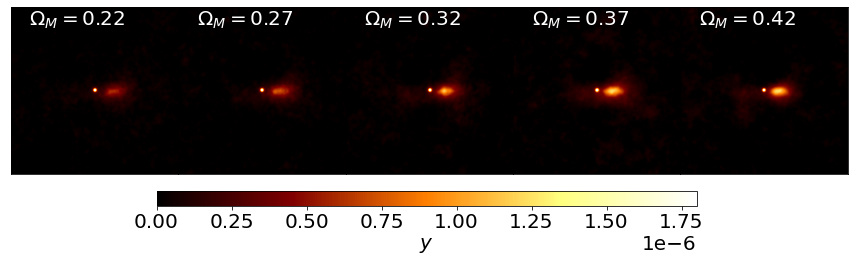

H0 varied:  [0.81515848 0.73433705 0.6736     0.62580529 0.58692566]
0.48648263011063164 Mpc / arcmin
ymap_pkpatch_OM22_fix_physdens_const_comov_massgt5e+13_0pt483_0pt516_nugt2_egtpt3_smth_20Mpc_41a_orient_100pct_halos_0pt466_0pt533_stk_HankelTransform_m2.txt
0.5301229964332904 Mpc / arcmin
ymap_pkpatch_OM27_fix_physdens_const_comov_massgt5e+13_0pt484_0pt515_nugt2_egtpt3_smth_20Mpc_37a_orient_100pct_halos_0pt468_0pt531_stk_HankelTransform_m2.txt
0.5678863636950662 Mpc / arcmin
ymap_pkpatch_OM32_fix_physdens_const_comov_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_35a_orient_100pct_halos_0pt470_0pt529_stk_HankelTransform_m2.txt
0.6011692552339125 Mpc / arcmin
ymap_pkpatch_OM37_fix_physdens_const_comov_massgt5e+13_0pt485_0pt514_nugt2_egtpt3_smth_20Mpc_33a_orient_100pct_halos_0pt471_0pt528_stk_HankelTransform_m2.txt
0.6309087387681642 Mpc / arcmin
ymap_pkpatch_OM42_fix_physdens_const_comov_massgt5e+13_0pt486_0pt513_nugt2_egtpt3_smth_20Mpc_31a_orient_100pct_halos_0pt472_0pt527_stk_Han

Text(0, 0.5, '$y$')

<Figure size 432x288 with 0 Axes>

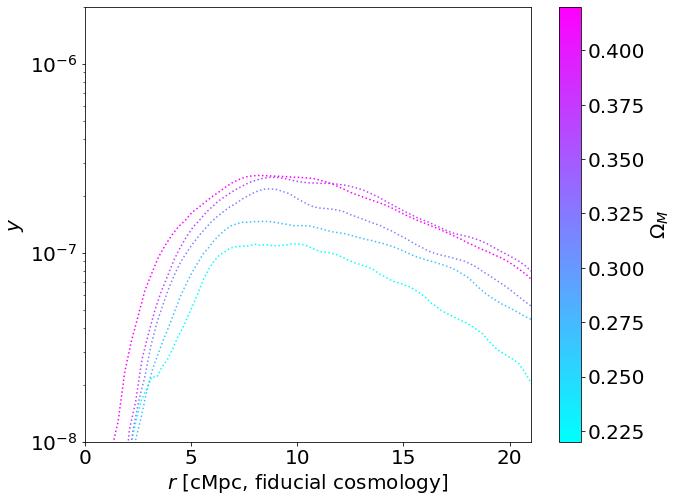

In [65]:
fix_density = True
constant_comoving = True
addon = ''
if fix_density:
    addon+='_fix_physdens'
if constant_comoving:
    addon+='_const_comov'


path = "/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/"

omegam_varied = [0.22, 0.27, 0.32, 0.37, 0.42]
i = 0
fig, ax = plt.subplots(1,5,figsize=[15,4])

for OMstring in ["OM22", "OM27", "OM32", "OM37", "OM42"]:
    
    OMstring += addon
    for file in os.listdir(path):
        if OMstring in file and f"_stk.fits" in file:
            print(file)
            hdu = fits.open(path+file)
    shape = hdu[0].shape[0]
    im = ax[i].imshow((hdu[0].data-np.mean(hdu[0].data))[60:shape-60, 60:shape-60], vmin=0, vmax=1.8e-6, cmap='afmhot')
    hdu.close()
    # Hide X and Y axes label marks
    ax[i].xaxis.set_tick_params(labelbottom=False)
    ax[i].yaxis.set_tick_params(labelleft=False)
    ax[i].text(40, 40, r"$\Omega_M = 0.{:s}$".format(OMstring[2:4]), color='white')
    # Hide X and Y axes tick marks
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    i+=1

# add a new axis below for a horizontal colorbar
fig.subplots_adjust(bottom=0.1)
plt.subplots_adjust(wspace=0.0, hspace=0.17)
ax_cbar = fig.add_axes([0.26, 0.09, 0.5, 0.05])
cbar = fig.colorbar(im, cax=ax_cbar, orientation='horizontal', label=r'$y$')
plt.show()
plt.clf()

i=0
fig, ax = plt.subplots(1,1,figsize=[10,8])
colormap = 'cool'
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0.22, vmax=0.42))
# get a color map that I can call by index
cm = plt.cm.get_cmap(colormap)

omegam_varied = np.linspace(P18_omegam-0.1,P18_omegam+0.1,5)
if fix_density:
    omegab_varied = omegam_varied*P18_omegab/P18_omegam # fix the baryon fraction
    omh2 = P18_omegam*P18_h**2
    h_varied = np.sqrt(omh2/omegam_varied)
    H0_varied = 100*h_varied
    print("H0 varied: ", h_varied)
    
else:
    omegab_varied = np.full(len(omegam_varied),P18_omegab)
    H0_varied = np.full(len(omegam_varied),P18.h*100)
    
integrals = []
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', 'solid']
for i in range(len(omegam_varied)):
    OMstring = "OM{:d}{:s}".format(int(round(omegam_varied[i]*100)), addon)
    new_cosmo = cosmology.setCosmology('newcosmo', params=cosmology.cosmologies['planck18-only'], Om0=omegam_varied[i], Ob0=omegab_varied[i], H0=H0_varied[i])
    new_cosmo_astropy = new_cosmo.toAstropy()
    mpc_per_arcmin = new_cosmo_astropy.kpc_comoving_per_arcmin(z).to(u.Mpc / u.arcmin)
    print(mpc_per_arcmin)
    ints_cosmo = []
    for m in range(2,3):
        for file in os.listdir(path):
            if OMstring in file and f"m{m}" in file:
                print(file)
                hankel = np.loadtxt(path+file)
                x = np.arange(len(hankel[:,0]))*arcmin_per_pix*mpc_per_arcmin # convert to comoving Mpc
                y = hankel[:,1]
                if m==0:
                    y -= np.average(hankel[:,1][-40:])
                ax.plot(x, y, color =cm(i/4), linestyle=linestyles[m])
                area = integrate(y, x.value, 100)[0]
                ints_cosmo.append(area)
    i+=1
    integrals.append(ints_cosmo)
log = True
cbar = plt.colorbar(sm)
cbar.set_label(r"$\Omega_M$")
if log:
    plt.yscale('log')
    ax.set_ylim([1e-8,2e-6])
else:
    ax.set_ylim([0,.5e-6])

# add text in whitespace describing the set of cosmological variations
if fix_density:
    text = "Cosmo2: variations with fixed $\Omega_M h^2$"
# ax.text(10, 1e-6, 

ax.set_xlim([0,21])

    
# secax = ax.secondary_xaxis('top', functions=(mpc_to_arcmin,arcmin_to_mpc))
# secax.set_xlabel('arcmin')

ax.set_xlabel('$r$ [cMpc, fiducial cosmology]')
ax.set_ylabel("$y$")

In [ ]:
fix_density = False
constant_comoving = True
addon = ''
if fix_density:
    addon+='_fix_physdens'
if constant_comoving:
    addon+='_const_comov'


path = "/mnt/raid-cita/mlokken/pkpatch/alt_cosmo_stacks/orient_by_halos_100/stacks/"

omegam_varied = [0.22, 0.27, 0.32, 0.37, 0.42]
i = 0
fig, ax = plt.subplots(1,5,figsize=[15,4])

for OMstring in ["OM22", "OM27", "OM32", "OM37", "OM42"]:
    
    OMstring += addon
    for file in os.listdir(path):
        if OMstring in file and f"_stk.fits" in file:
            print(file)
            hdu = fits.open(path+file)
    shape = hdu[0].shape[0]
    im = ax[i].imshow((hdu[0].data-np.mean(hdu[0].data))[60:shape-60, 60:shape-60], vmin=0, vmax=1.8e-6, cmap='afmhot')
    hdu.close()
    # Hide X and Y axes label marks
    ax[i].xaxis.set_tick_params(labelbottom=False)
    ax[i].yaxis.set_tick_params(labelleft=False)
    ax[i].text(40, 40, r"$\Omega_M = 0.{:s}$".format(OMstring[2:4]), color='white')
    # Hide X and Y axes tick marks
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    i+=1

# add a new axis below for a horizontal colorbar
fig.subplots_adjust(bottom=0.1)
plt.subplots_adjust(wspace=0.0, hspace=0.17)
ax_cbar = fig.add_axes([0.26, 0.09, 0.5, 0.05])
cbar = fig.colorbar(im, cax=ax_cbar, orientation='horizontal', label=r'$y$')
plt.show()
plt.clf()

i=0
fig, ax = plt.subplots(1,1,figsize=[10,8])
colormap = 'cool'
sm = plt.cm.ScalarMappable(cmap=colormap, norm=plt.Normalize(vmin=0.22, vmax=0.42))
# get a color map that I can call by index
cm = plt.cm.get_cmap(colormap)

omegam_varied = np.linspace(P18_omegam-0.1,P18_omegam+0.1,5)
if fix_density:
    omegab_varied = omegam_varied*P18_omegab/P18_omegam # fix the baryon fraction
    omh2 = P18_omegam*P18_h**2
    h_varied = np.sqrt(omh2/omegam_varied)
    H0_varied = 100*h_varied
    print("H0 varied: ", h_varied)
    
else:
    omegab_varied = np.full(len(omegam_varied),P18_omegab)
    H0_varied = np.full(len(omegam_varied),P18.h*100)
    
integrals = []
linestyles = ['solid', 'dashed', 'dotted', 'dashdot', 'solid']
for i in range(len(omegam_varied)):
    OMstring = "OM{:d}{:s}".format(int(round(omegam_varied[i]*100)), addon)
    new_cosmo = cosmology.setCosmology('newcosmo', params=cosmology.cosmologies['planck18-only'], Om0=omegam_varied[i], Ob0=omegab_varied[i], H0=H0_varied[i])
    new_cosmo_astropy = new_cosmo.toAstropy()
    mpc_per_arcmin = new_cosmo_astropy.kpc_comoving_per_arcmin(z).to(u.Mpc / u.arcmin)
    
    ints_cosmo = []
    for m in range(0,2):
        for file in os.listdir(path):
            if OMstring in file and f"m{m}" in file:
                print(file)
                hankel = np.loadtxt(path+file)
                x = np.arange(len(hankel[:,0]))*arcmin_per_pix*mpc_per_arcmin # convert to comoving Mpc
                y = hankel[:,1]
                if m==0:
                    y -= np.average(hankel[:,1][-40:])
                ax.plot(x, y, color =cm(i/4), linestyle=linestyles[m])
                area = integrate(y, x.value, 100)[0]
                ints_cosmo.append(area)
    i+=1
    integrals.append(ints_cosmo)
log = True
cbar = plt.colorbar(sm)
cbar.set_label(r"$\Omega_M$")
if log:
    plt.yscale('log')
    ax.set_ylim([1e-8,2e-6])
else:
    ax.set_ylim([0,.5e-6])

# add text in whitespace describing the set of cosmological variations
if fix_density:
    text = "Cosmo2: variations with fixed $\Omega_M h^2$"
# ax.text(10, 1e-6, 

ax.set_xlim([0,21])

    
# secax = ax.secondary_xaxis('top', functions=(mpc_to_arcmin,arcmin_to_mpc))
# secax.set_xlabel('arcmin')

ax.set_xlabel('$r$ [cMpc, fiducial cosmology]')
ax.set_ylabel("$y$")